# k-Nearest Neighbor (kNN) exercise


The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

## 张泽亿问题分析   

　　首先我们明确我们的问题是一个图像分类问题。就是已有固定的分类标签集合，然后对于输入的图像，从分类标签集合中找出一个分类标签，最后把分类标签分配给该输入图像。<br>
　　然后我们再分析我们所使用的数据集CIFAR-10。 <br>
　　CIFAR-10数据集由10个类的60000个32x32彩色图像组成，每个类有6000个图像。有50000个训练图像和10000个测试图像。<br>
　　接下来我们分析问题实现方法：<br>
　　１. 输入：输入是包含N个图像的集合，每个图像的标签是各种分类标签中的一种。这个集合为训练集。对于每张图片来说。我们都可以将其视作一个三维数组，这个三维数组大小为32x32x3，代表图像的像素和RGB三个通道。为了便于计算。我们可以将其中任一张图片将其拉伸成为一个长为3072的矩阵，这样我们的输入就是一个Nx3072的大矩阵。<br>
　　２. 学习：这一步我们的任务是使用训练集来学习每个类到底长什么样。对于分类，最先想到的就是两张图片越相似，他们的类型就越可能一样，那么如何比较两个图片的相似度，就是逐一比较32x32x3（3072）的像素的差异然后对其求和。也就是说，我们可以将其转化为求两个长为3072的向量的距离（欧式距离，曼哈顿距离）然后求和。结合本学期我们所学的分类方法，所以先使用KNN来计算。<br>
　　３. 评价：通过训练，让我们所学习到的模型来预测它未曾见过的图像的分类标签，并以此来评价我们模型的质量。我们将预测的标签和图像真正的分类标签对比。如果一致的越多，效果越好。如若效果不佳，而且确保我们的模型没有问题，由于数据量不大，我们可以选择新的方法来解决问题。

## 鲍骞月问题分析

* 数据集分析   
    CIFAR-10数据集包含10个不同类别的60000个32x32彩色图像    
    10个不同的类别代表飞机，汽车，鸟类，猫，鹿，狗，青蛙，马，船和卡车。每个类别有6000张图片    
* 问题分析   
    如果直接使用全部像素点作为图像特征，不仅计算复杂度非常高，还有相当多的噪声信息    
    为了进一步提升准确率，我们就必须提取出图片更容易区分的特征，再将这些特征当做特征向量进行分类    
    使用HOG和HSV分别提取，HOG提取图像的纹理特征，而忽略了颜色信息，颜色直方图会表示图像的颜色特征而忽略了纹理特征，因此将这两者的特征结合起来作为特征向量    
    特征提取后可以将图像特征从3072降到154，可以提高计算速度和分类准确率。      

## 景金龙问题分析 

        CIFAIR-10该数据集共有60000张彩色图像，这些图像是32*32，分为10个类。每个像素点包括RGB三个数值，数值范围 0 ~ 255。我们可以考虑通过计算每个像素点之间的距离来计算图片之间的距离，最后通过图片的距离来实现分类。
    问题实现：
        通过距离来实现分类就可以使用KNN算法。
       1.首先确定输入，我们可以将彩色图片的三个32*32的数组拉成一行，使每张图片的数据成为一行（即输入数据为N*3072的一个大矩阵）。
       2.然后计算距离，将图像转成二维后就可以分别计算出每张图片之间的距离。再通过最近的距离K来确定具体分类。
       3.可以用交叉验证来确定超参K的取值来使模型的效果达到最好。
       4.在测试数据上进行预测并计算准确率。如果准确率不是很高可以再换一种算法来计算。

## 许瑞洋问题分析

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from DSVC.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

In [6]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'DSVC/datasets/cifar-10-batches-py' # you should change it to your own path, 
                                                    # or put the dataset to this path


# To avoid some memory problem, we load 3 batch of the data(30000 images).
# You can change the number '3' to '6' to load the hole dataset(60000 images).
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir, 3)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (20000, 32, 32, 3)
Training labels shape:  (20000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


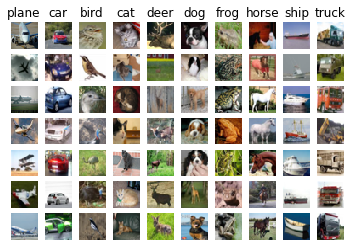

In [7]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# # Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [9]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print (X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [10]:
from DSVC.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `DSVC/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [13]:
# Open DSVC/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print (dists.shape)

(500, 5000)


In [14]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [15]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 143 / 500 correct => accuracy: 0.286000


You should expect to see a slightly better performance than with `k = 1`.

In [16]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print ('Difference was: %f' % (difference, ))
if difference < 0.001:
    print ('Good! The distance matrices are the same')
else:
    print ('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [17]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print ('Difference was: %f' % (difference, ))
if difference < 0.001:
    print ('Good! The distance matrices are the same')
else:
    print ('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [18]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print ('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print ('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print ('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 37.323159 seconds
One loop version took 74.084821 seconds
No loop version took 0.373999 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

There are three kinds of validation methods([introduction to these methods](http://www.cnblogs.com/zhaohongtian/p/6802327.html)). The method below is S-Folder Cross Validation. If it's difficult for you, use the simple cross-validation alternatively. 

In [19]:
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir, 6)
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [20]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print (X_train.shape, X_test.shape)

(50000, 3072) (10000, 3072)


In [21]:
# pass 部分是需要你去补上相应的代码的，代码的要求都在pass上面的ToDo:里写清楚了。
# pass 是python里的占位语句，也就是空语句，写你的代码的时候 要先把pass给删掉。
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
print("length of x_train_folds", len(X_train_folds))
print("X_train shape", type(X_train[0]))
print("X_train len", X_train_folds[0].shape)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}
################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    k_to_accuracies[k] = []
    
    for index in range(num_folds):
        
        X_te = X_train_folds[index]
        y_te = y_train_folds[index]

        X_tr = np.vstack([X_train_folds[x] for x in range(num_folds) if x != index])
        y_tr = np.hstack([y_train_folds[x] for x in range(num_folds) if x != index])
        
        classify = KNearestNeighbor()
        classify.train(X_tr, y_tr)
        y_te_pred = classify.predict(X_te, k, 0)
        accuracy = np.sum(y_te_pred == y_te)
        k_to_accuracies[k].append(accuracy/y_te.shape[0])
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# 输出每次的准确度
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print ('k = %d, accuracy = %f' % (k, accuracy))

length of x_train_folds 5
X_train shape <class 'numpy.ndarray'>
X_train len (10000, 3072)
k = 1, accuracy = 0.335800
k = 1, accuracy = 0.336100
k = 1, accuracy = 0.346900
k = 1, accuracy = 0.334600
k = 1, accuracy = 0.338300
k = 3, accuracy = 0.345100
k = 3, accuracy = 0.346600
k = 3, accuracy = 0.350300
k = 3, accuracy = 0.338400
k = 3, accuracy = 0.336800
k = 5, accuracy = 0.347900
k = 5, accuracy = 0.344100
k = 5, accuracy = 0.349500
k = 5, accuracy = 0.340900
k = 5, accuracy = 0.339700
k = 8, accuracy = 0.350100
k = 8, accuracy = 0.339100
k = 8, accuracy = 0.347300
k = 8, accuracy = 0.340500
k = 8, accuracy = 0.336100
k = 10, accuracy = 0.344900
k = 10, accuracy = 0.334900
k = 10, accuracy = 0.341400
k = 10, accuracy = 0.334700
k = 10, accuracy = 0.332000
k = 12, accuracy = 0.344300
k = 12, accuracy = 0.330800
k = 12, accuracy = 0.336200
k = 12, accuracy = 0.332400
k = 12, accuracy = 0.331900
k = 15, accuracy = 0.339100
k = 15, accuracy = 0.329500
k = 15, accuracy = 0.332900
k = 15

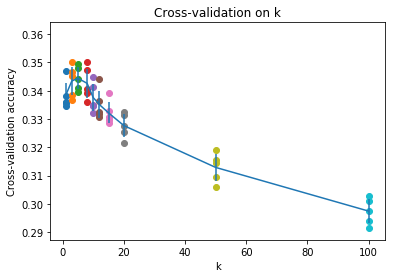

In [22]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [26]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 5
num_test = 10000
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / 10000
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 3546 / 10000 correct => accuracy: 0.354600


In [15]:
# 加上特征提取
from DSVC.features import *

# 重新加载数据
# Load the raw CIFAR-10 data.
cifar10_dir = 'DSVC/datasets/cifar-10-batches-py' # you should change it to your own path, 
                                                    # or put the dataset to this path


# To avoid some memory problem, we load 3 batch of the data(30000 images).
# You can change the number '3' to '6' to load the hole dataset(60000 images).
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir, 6)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)


# 特征提取
num_color_bins = 10
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_test_feats = extract_features(X_test, feature_fns)

# 图像特征标准化
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_test_feats -= mean_feat
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_test_feats /= std_feat

print(X_train_feats.shape, X_test_feats.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Done extracting features for 10000 / 50000 images
Done extracting features for 20000 / 50000 images
Done extracting features for 30000 / 50000 images
Done extracting features for 40000 / 50000 images
(50000, 154) (10000, 154)


In [16]:
# 将数据拉成一行
X_train_feats = np.reshape(X_train_feats, (X_train_feats.shape[0], -1))
X_test_feats = np.reshape(X_test_feats, (X_test_feats.shape[0], -1))
print (X_train_feats.shape, X_test_feats.shape)

best_k = 5
num_test = 10000
classifier = KNearestNeighbor()
classifier.train(X_train_feats, y_train)
y_test_pred = classifier.predict(X_test_feats, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / 10000
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

(50000, 154) (10000, 154)
Got 4345 / 10000 correct => accuracy: 0.434500
